# Fantasy Point Prediction Evaluation

## Setup

Import the necessary libraries

In [1]:
# for data
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
from functools import reduce
import pandas as pd
import numpy as np

# for models
from sklearn.model_selection import train_test_split
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.points_per_second import PPSModel
from pyNBA.Models.made_threes_per_second import MTPSModel
from pyNBA.Models.rebounds_per_second import RPSModel
from pyNBA.Models.assists_per_second import APSModel
from pyNBA.Models.turnovers_per_second import TPSModel
from pyNBA.Models.steals_per_second import SPSModel
from pyNBA.Models.blocks_per_second import BPSModel
from pyNBA.Models.seconds import SecondsModel

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import abline_plot

# for evaluation
from sklearn import metrics

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Generate Individual Stats

In [2]:
%%time

query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

quarterly_boxscore_data = query_data.query_quarterly_boxscore_data()
odds_data = query_data.query_odds_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0
CPU times: user 23.5 s, sys: 1.82 s, total: 25.3 s
Wall time: 1min 30s


In [3]:
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)
boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']
boxscores['DKFP'] = boxscores.apply(
    lambda x: DKFPCalculator.calculate_draftkings_fp(x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']), 
    axis=1
)

feature_creation = FeatureCreation()
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='AVG_DKFP'
)

In [4]:
train_data, test_data = train_test_split(boxscores, test_size=0.25)

In [5]:
%%time

pps_model = PPSModel(train_data, test_data)
pps_model.create_features()
pps_model.train_model()
pps_pred = pps_model.predict()

CPU times: user 10min 20s, sys: 20.2 s, total: 10min 40s
Wall time: 10min 13s


In [6]:
%%time

mtps_model = MTPSModel(train_data, test_data)
mtps_model.create_features(odds_data)
mtps_model.train_model()
mtps_pred = mtps_model.predict()

CPU times: user 9min 33s, sys: 26.9 s, total: 10min
Wall time: 9min


In [7]:
%%time

rps_model = RPSModel(train_data, test_data)
rps_model.create_features(odds_data)
rps_model.train_model()
rps_pred = rps_model.predict()

CPU times: user 8min 40s, sys: 12.5 s, total: 8min 52s
Wall time: 8min 26s


In [8]:
%%time

aps_model = APSModel(train_data, test_data)
aps_model.create_features(odds_data)
aps_model.train_model()
aps_pred = aps_model.predict()

CPU times: user 7min 39s, sys: 9.44 s, total: 7min 48s
Wall time: 7min 38s


In [9]:
%%time

tps_model = TPSModel(train_data, test_data)
tps_model.create_features(odds_data)
tps_model.train_model()
tps_pred = tps_model.predict()

CPU times: user 1min 51s, sys: 4.04 s, total: 1min 55s
Wall time: 1min 40s


In [10]:
%%time

sps_model = SPSModel(train_data, test_data)
sps_model.create_features(odds_data)
sps_model.train_model()
sps_pred = sps_model.predict()

CPU times: user 3min 29s, sys: 6.55 s, total: 3min 36s
Wall time: 3min 15s


In [11]:
%%time

bps_model = BPSModel(train_data, test_data)
bps_model.create_features(odds_data)
bps_model.train_model()
bps_pred = bps_model.predict()

CPU times: user 3min, sys: 4.88 s, total: 3min 5s
Wall time: 3min 3s


In [12]:
%%time

seconds_model = SecondsModel(train_data, test_data)
seconds_model.create_features(quarterly_boxscore_data, odds_data)
seconds_model.train_model()
sp_pred = seconds_model.predict()

CPU times: user 11min 18s, sys: 1min 23s, total: 12min 41s
Wall time: 7min 40s


# Generate Fantasy Point Predictions

In [49]:
dataframes = [test_data, pps_pred, mtps_pred, rps_pred, aps_pred, tps_pred, bps_pred, sps_pred, sp_pred]
preds = reduce(lambda left,right: pd.merge(left,right, on=['GAMEID', 'PLAYERID'], how='outer'), dataframes)

In [50]:
preds['DKFPPS_HAT'] = preds.apply(
    lambda x: DKFPCalculator.calculate_draftkings_fp(
        x['PPS_HAT'], x['RPS_HAT'], x['APS_HAT'],
        x['TPS_HAT'], x['BPS_HAT'], x['SPS_HAT'], x['MTPS_HAT']
    ), 
    axis=1
)
preds['DKFP_HAT'] = preds['SECONDSPLAYED_HAT']*preds['DKFPPS_HAT']
# preds = preds.dropna(subset=['DKFP', 'AVG_DKFP', 'DKFP_HAT'])

In [57]:
a = preds.loc[
    (preds['DATE'] == '2017-11-20') & (preds['TEAM'] == 'IND')
]
pd.set_option('display.min_rows', 200)
display(a[['DATE', 'NAME', 'TEAM', 'PPS_HAT', 'RPS_HAT', 'APS_HAT', 'TPS_HAT', 'BPS_HAT', 'SPS_HAT', 'MTPS_HAT', 'SECONDSPLAYED_HAT', 'DKFP_HAT']])
print(a.dropna(subset=['DKFP_HAT']).shape[0])
print(len(list(a['TEAM'].unique())))
print(a.dropna(subset=['DKFP_HAT']).shape[0]/len(list(a['TEAM'].unique())))

,DATE,NAME,TEAM,PPS_HAT,RPS_HAT,APS_HAT,TPS_HAT,BPS_HAT,SPS_HAT,MTPS_HAT,SECONDSPLAYED_HAT,DKFP_HAT
16865,2017-11-20,Al Jefferson,IND,0.007620,0.005482,0.001318,0.000853,0.000582,0.000539,0.000040,140.199304,2.563686
37065,2017-11-20,Victor Oladipo,IND,0.011143,0.002411,0.002009,0.001550,0.000344,0.000651,0.001034,2070.601861,39.143318


2
1
2.0


# Evaluate

In [15]:
# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(preds['DKFP'], preds['DKFP_HAT']), 3))
print("Baseline:", round(metrics.r2_score(preds['DKFP'], preds['AVG_DKFP']), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(preds['DKFP'], preds['DKFP_HAT']), 6))
print("Baseline:", round(metrics.mean_absolute_error(preds['DKFP'], preds['AVG_DKFP']), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(preds['DKFP'], preds['DKFP_HAT'])), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(preds['DKFP'], preds['AVG_DKFP'])), 6))

R2 (explained variance):
Model: 0.656
Baseline: 0.589

Mean Absolute Error (Σ|y-pred|/n):
Model: 6.618276
Baseline: 7.264736

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 8.740503
Baseline: 9.562226


No handles with labels found to put in legend.
No handles with labels found to put in legend.


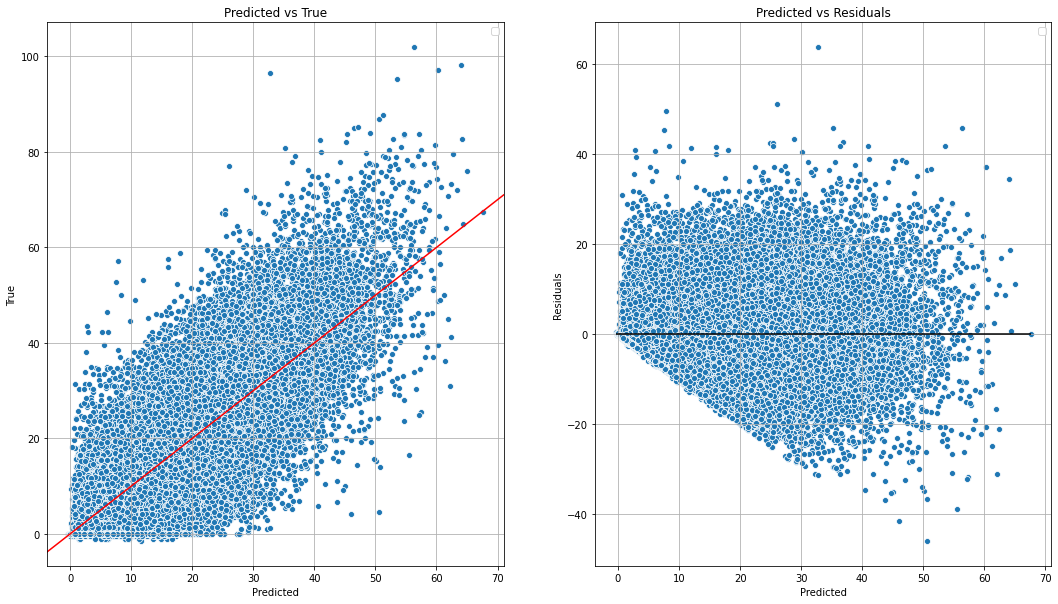

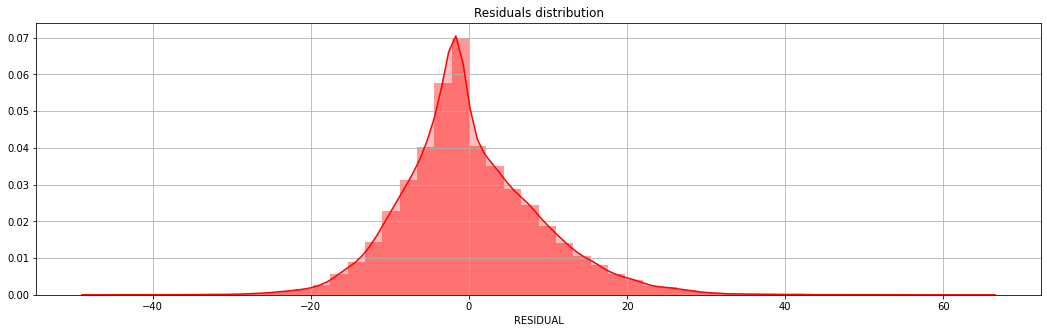

In [16]:
preds['RESIDUAL'] = preds['DKFP'] - preds['DKFP_HAT']

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(preds['DKFP_HAT'], preds['DKFP'], ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(preds['DKFP_HAT'], preds['RESIDUAL'], ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(preds['DKFP_HAT']), xmax=np.max(preds['DKFP_HAT']))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(preds['RESIDUAL'], color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [17]:
temp = preds.loc[(preds['DKFP'] > 0)]

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(temp['DKFP'], temp['DKFP_HAT']), 3))
print("Baseline:", round(metrics.r2_score(temp['DKFP'], temp['AVG_DKFP']), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(temp['DKFP'], temp['DKFP_HAT']), 6))
print("Baseline:", round(metrics.mean_absolute_error(temp['DKFP'], temp['AVG_DKFP']), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(temp['DKFP'], temp['DKFP_HAT'])), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(temp['DKFP'], temp['AVG_DKFP'])), 6))

R2 (explained variance):
Model: 0.556
Baseline: 0.478

Mean Absolute Error (Σ|y-pred|/n):
Model: 7.108296
Baseline: 7.674717

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 9.228359
Baseline: 10.010192
